<a href="https://colab.research.google.com/github/Gakkilovemath/PPL_in_prodcution/blob/master/Test_numpyro.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
# this notebook is for testing numpyro purpose

# Demo test

In [12]:
import numpy as np
import numpyro
import jax
import inspect
from jax import grad
# !pip install numpyro
# !pip install arviz causalgraphicalmodels daft
from IPython.display import set_matplotlib_formats
import jax.numpy as jnp
from jax import random, vmap
from jax.scipy.special import logsumexp
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import arviz as az
import daft
from numpyro.diagnostics import hpdi
import numpyro.distributions as dist
from numpyro import handlers
from numpyro.infer import MCMC, NUTS

import numpyro.optim as optim
from numpyro.diagnostics import print_summary
from numpyro.infer import ELBO, SVI, Predictive
from numpyro.infer.autoguide import AutoLaplaceApproximation
from numpyro.infer import ELBO, SVI, Predictive, init_to_value, log_likelihood

plt.style.use('bmh')

assert numpyro.__version__.startswith('0.3.0')

In [3]:
DATASET_URL = 'https://raw.githubusercontent.com/rmcelreath/rethinking/master/data/WaffleDivorce.csv'
dset = pd.read_csv(DATASET_URL, sep=';')
dset.head(3)

,Location,Loc,Population,MedianAgeMarriage,Marriage,Marriage SE,Divorce,Divorce SE,WaffleHouses,South,Slaves1860,Population1860,PropSlaves1860
0,Alabama,AL,4.78,25.3,20.2,1.27,12.7,0.79,128,1,435080,964201,0.45
1,Alaska,AK,0.71,25.2,26.0,2.93,12.5,2.05,0,0,0,0,0.00
2,Arizona,AZ,6.33,25.8,20.3,0.98,10.8,0.74,18,0,0,0,0.00


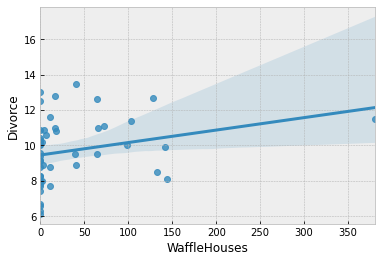

In [7]:
sns.regplot('WaffleHouses', 'Divorce', dset);

In [8]:
standardize = lambda x: (x - x.mean()) / x.std()

dset['AgeScaled'] = dset.MedianAgeMarriage.pipe(standardize)
dset['MarriageScaled'] = dset.Marriage.pipe(standardize)
dset['DivorceScaled'] = dset.Divorce.pipe(standardize)

In [9]:
def model(marriage=None, age=None, divorce=None):
    a = numpyro.sample('a', dist.Normal(0., 0.2))
    M, A = 0., 0.
    if marriage is not None:
        bM = numpyro.sample('bM', dist.Normal(0., 0.5))
        M = bM * marriage
    if age is not None:
        bA = numpyro.sample('bA', dist.Normal(0., 0.5))
        A = bA * age
    sigma = numpyro.sample('sigma', dist.Exponential(1.))
    mu = a + M + A
    numpyro.sample('obs', dist.Normal(mu, sigma), obs=divorce)

In [10]:
# Start from this source of randomness. We will split keys for subsequent operations.
rng_key = random.PRNGKey(0)
rng_key, rng_key_ = random.split(rng_key)

num_warmup, num_samples = 200, 1000

# Run NUTS.
kernel = NUTS(model)
mcmc = MCMC(kernel, num_warmup, num_samples)
mcmc.run(rng_key_, marriage=dset.MarriageScaled.values, divorce=dset.DivorceScaled.values)
mcmc.print_summary()
samples_1 = mcmc.get_samples()

sample: 100%|██████████| 1200/1200 [00:04<00:00, 251.11it/s, 3 steps of size 8.06e-01. acc. prob=0.90]



                mean       std    median      5.0%     95.0%     n_eff     r_hat
         a      0.00      0.11      0.01     -0.16      0.19    713.70      1.00
        bM      0.34      0.13      0.34      0.15      0.57   1125.77      1.00
     sigma      0.95      0.10      0.94      0.81      1.11    872.68      1.00

Number of divergences: 0


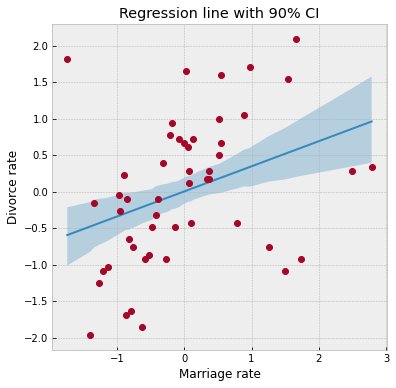

In [11]:
def plot_regression(x, y_mean, y_hpdi):
    # Sort values for plotting by x axis
    idx = jnp.argsort(x)
    marriage = x[idx]
    mean = y_mean[idx]
    hpdi = y_hpdi[:, idx]
    divorce = dset.DivorceScaled.values[idx]

    # Plot
    fig, ax = plt.subplots(nrows=1, ncols=1, figsize=(6, 6))
    ax.plot(marriage, mean)
    ax.plot(marriage, divorce, 'o')
    ax.fill_between(marriage, hpdi[0], hpdi[1], alpha=0.3, interpolate=True)
    return ax

# Compute empirical posterior distribution over mu
posterior_mu = jnp.expand_dims(samples_1['a'], -1) + \
               jnp.expand_dims(samples_1['bM'], -1) * dset.MarriageScaled.values

mean_mu = jnp.mean(posterior_mu, axis=0)
hpdi_mu = hpdi(posterior_mu, 0.9)
ax = plot_regression(dset.MarriageScaled.values, mean_mu, hpdi_mu)
ax.set(xlabel='Marriage rate', ylabel='Divorce rate', title='Regression line with 90% CI');

In [12]:
from numpyro.infer import Predictive

rng_key, rng_key_ = random.split(rng_key)
predictive = Predictive(model, samples_1)
predictions = predictive(rng_key_, marriage=dset.MarriageScaled.values)['obs']
df = dset.filter(['Location'])
df['Mean Predictions'] = jnp.mean(predictions, axis=0)
df.head()

,Location,Mean Predictions
0,Alabama,0.018611
1,Alaska,0.585065
2,Arizona,0.028662
3,Arkansas,0.541747
4,California,-0.049739


# SVI Inference

In [22]:
WaffleDivorce = pd.read_csv("WaffleDivorce.csv", sep=";")
d = WaffleDivorce

# standardize variables
d["A"] = d.MedianAgeMarriage.pipe(lambda x: (x - x.mean()) / x.std())
d["D"] = d.Divorce.pipe(lambda x: (x - x.mean()) / x.std())
d["M"] = d.Marriage.pipe(lambda x: (x - x.mean()) / x.std())

In [23]:
def model(A, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bA * A)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


m5_1 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_1, optim.Adam(1), ELBO(), A=d.A.values, D=d.D.values)
init_state = svi.init(random.PRNGKey(0))
state, loss = jax.lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
p5_1 = svi.get_params(state)

In [24]:
def model(M, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a + bM * M
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)


m5_2 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_2, optim.Adam(1), ELBO(), M=d.M.values, D=d.D.values)
init_state = svi.init(random.PRNGKey(0))
state, loss = jax.lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
p5_2 = svi.get_params(state)

In [25]:
# using svid
def model(M, A, D=None):
    a = numpyro.sample("a", dist.Normal(0, 0.2))
    bM = numpyro.sample("bM", dist.Normal(0, 0.5))
    bA = numpyro.sample("bA", dist.Normal(0, 0.5))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = numpyro.deterministic("mu", a + bM * M + bA * A)
    numpyro.sample("D", dist.Normal(mu, sigma), obs=D)

m5_3 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_3, optim.Adam(1), ELBO(), M=d.M.values, A=d.A.values, D=d.D.values)
init_state = svi.init(random.PRNGKey(0))
state, loss = jax.lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
p5_3 = svi.get_params(state)
post = m5_3.sample_posterior(random.PRNGKey(1), p5_3, (1000,))
#print_summary(post, 0.89, False)



In [27]:
az.compare(
    {"m5.1": az.from_numpyro(m5_1),
     "m5.2": az.from_numpyro(m5_2),
     "m5.3": az.from_numpyro(m5_3)},
    ic="waic",
    scale="deviance",
)

AttributeError: ignored

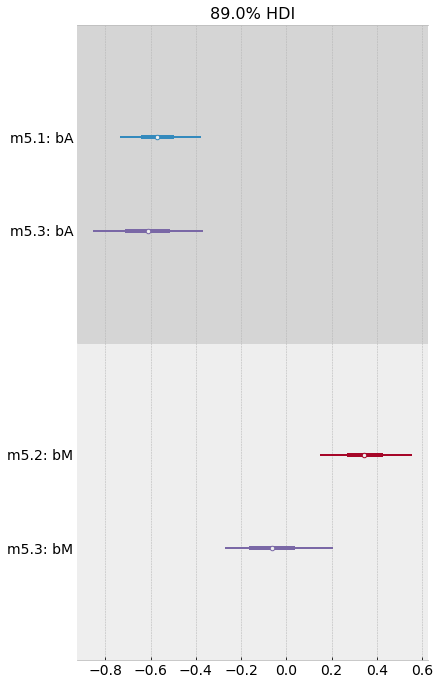

In [26]:
# compare three models
coeftab = {
    "m5.1": m5_1.sample_posterior(random.PRNGKey(1), p5_1, (1, 1000,)),
    "m5.2": m5_2.sample_posterior(random.PRNGKey(2), p5_2, (1, 1000,)),
    "m5.3": m5_3.sample_posterior(random.PRNGKey(3), p5_3, (1, 1000,)),
}
az.plot_forest(
    list(coeftab.values()),
    model_names=list(coeftab.keys()),
    var_names=["bA", "bM"],
    hdi_prob=0.89,
)
plt.show()

# Categorical

In [43]:
milk = pd.read_csv("milk.csv", sep=";")
d = milk
d.clade.unique()

array(['Strepsirrhine', 'New World Monkey', 'Old World Monkey', 'Ape'],
      dtype=object)

In [45]:
d["clade_id"] = d.clade.astype("category").cat.codes
d["K"] = d["kcal.per.g"].pipe(lambda x: (x - x.mean()) / x.std())

In [46]:
def model(clade_id, K):
    a = numpyro.sample("a", dist.Normal(0, 0.5).expand([len(set(clade_id))]))
    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = a[clade_id]
    numpyro.sample("height", dist.Normal(mu, sigma), obs=K)

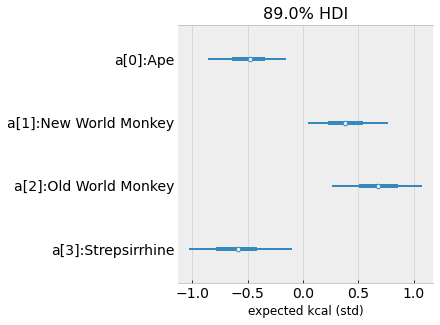

In [48]:
m5_9 = AutoLaplaceApproximation(model)
svi = SVI(model, m5_9, optim.Adam(1), ELBO(), clade_id=d.clade_id.values, K=d.K.values)
init_state = svi.init(random.PRNGKey(0))
state, loss = jax.lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
p5_9 = svi.get_params(state)
post = m5_9.sample_posterior(random.PRNGKey(1), p5_9, (1000,))
labels = ["a[" + str(i) + "]:" + s for i, s in enumerate(sorted(d.clade.unique()))]
az.plot_forest({"a": post["a"][None, ...]}, hdi_prob=0.89)
plt.gca().set(yticklabels=labels[::-1], xlabel="expected kcal (std)")
plt.show()

In [51]:
sppnames = [
    "afarensis",
    "africanus",
    "habilis",
    "boisei",
    "rudolfensis",
    "ergaster",
    "sapiens",
]
brainvolcc = jnp.array([438, 452, 612, 521, 752, 871, 1350])
masskg = jnp.array([37.0, 35.5, 34.5, 41.5, 55.5, 61.0, 53.5])
d = pd.DataFrame({"species": sppnames, "brain": brainvolcc, "mass": masskg})
d["mass_std"] = (d.mass - d.mass.mean()) / d.mass.std()
d["brain_std"] = d.brain / d.brain.max()
d

,species,brain,mass,mass_std,brain_std
0,afarensis,438,37.0,-0.779467,0.324444
1,africanus,452,35.5,-0.917020,0.334815
2,habilis,612,34.5,-1.008722,0.453333
3,boisei,521,41.5,-0.366808,0.385926
4,rudolfensis,752,55.5,0.917020,0.557037
5,ergaster,871,61.0,1.421380,0.645185
6,sapiens,1350,53.5,0.733616,1.000000


In [52]:
 def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = numpyro.deterministic("mu", a + b * mass_std)
    numpyro.sample("brain_std", dist.Normal(mu, jnp.exp(log_sigma)), obs=brain_std)

In [53]:
from jax import lax

In [55]:
m7_1 = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m7_1,
    optim.Adam(0.3),
    ELBO(),
    mass_std=d.mass_std.values,
    brain_std=d.brain_std.values,
)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
p7_1 = svi.get_params(state)

In [56]:
def model(mass_std, brain_std):
    intercept = numpyro.sample("intercept", dist.Normal(0, 10))
    b_mass_std = numpyro.sample("b_mass_std", dist.Normal(0, 10))
    sigma = numpyro.sample("sigma", dist.HalfCauchy(2))
    mu = intercept + b_mass_std * mass_std
    numpyro.sample("brain_std", dist.Normal(mu, sigma), obs=brain_std)


m7_1_OLS = AutoLaplaceApproximation(model)
svi = SVI(
    model,
    m7_1_OLS,
    optim=optim.Adam(0.01),
    loss=ELBO(),
    mass_std=d.mass_std.values,
    brain_std=d.brain_std.values,
)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(1000))
p7_1_OLS = svi.get_params(state)
post = m7_1_OLS.sample_posterior(random.PRNGKey(1), p7_1_OLS, (1000,))

In [57]:
post = m7_1.sample_posterior(random.PRNGKey(12), p7_1, (1000,))
s = Predictive(m7_1.model, post)(random.PRNGKey(2), d.mass_std.values)
r = jnp.mean(s["brain_std"], 0) - d.brain_std.values
resid_var = jnp.var(r, ddof=1)
outcome_var = jnp.var(d.brain_std.values, ddof=1)
1 - resid_var / outcome_var

DeviceArray(0.49277937, dtype=float32)

In [60]:
def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10).expand([2]))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = numpyro.deterministic("mu", a + b[0] * mass_std + b[1] * mass_std ** 2)
    numpyro.sample("brain_std", dist.Normal(mu, jnp.exp(log_sigma)), obs=brain_std)


m7_2 = AutoLaplaceApproximation(
    model, init_strategy=init_to_value(values={"b": jnp.repeat(0.0, 2)})
)
svi = SVI(
    model,
    m7_2,
    optim.Adam(0.3),
    ELBO(),
    mass_std=d.mass_std.values,
    brain_std=d.brain_std.values,
)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(2000))
p7_2 = svi.get_params(state)

In [61]:
def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10).expand([3]))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = numpyro.deterministic(
        "mu", a + b[0] * mass_std + b[1] * mass_std ** 2 + b[2] * mass_std ** 3
    )
    numpyro.sample("brain_std", dist.Normal(mu, jnp.exp(log_sigma)), obs=brain_std)


m7_3 = AutoLaplaceApproximation(
    model, init_strategy=init_to_value(values={"b": jnp.repeat(0.0, 3)})
)
svi = SVI(
    model,
    m7_3,
    optim.Adam(0.01),
    ELBO(),
    mass_std=d.mass_std.values,
    brain_std=d.brain_std.values,
)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(2000))
p7_3 = svi.get_params(state)


def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10).expand([4]))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = numpyro.deterministic(
        "mu", a + jnp.sum(b * jnp.power(mass_std[..., None], jnp.arange(1, 5)), -1)
    )
    numpyro.sample("brain_std", dist.Normal(mu, jnp.exp(log_sigma)), obs=brain_std)


m7_4 = AutoLaplaceApproximation(
    model, init_strategy=init_to_value(values={"b": jnp.repeat(0.0, 4)})
)
svi = SVI(
    model,
    m7_4,
    optim.Adam(0.01),
    ELBO(),
    mass_std=d.mass_std.values,
    brain_std=d.brain_std.values,
)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(2000))
p7_4 = svi.get_params(state)


def model(mass_std, brain_std=None):
    a = numpyro.sample("a", dist.Normal(0.5, 1))
    b = numpyro.sample("b", dist.Normal(0, 10).expand([5]))
    log_sigma = numpyro.sample("log_sigma", dist.Normal(0, 1))
    mu = numpyro.deterministic(
        "mu", a + jnp.sum(b * jnp.power(mass_std[..., None], jnp.arange(1, 6)), -1)
    )
    numpyro.sample("brain_std", dist.Normal(mu, jnp.exp(log_sigma)), obs=brain_std)


m7_5 = AutoLaplaceApproximation(
    model, init_strategy=init_to_value(values={"b": jnp.repeat(0.0, 5)})
)
svi = SVI(
    model,
    m7_5,
    optim.Adam(0.01),
    ELBO(),
    mass_std=d.mass_std.values,
    brain_std=d.brain_std.values,
)
init_state = svi.init(random.PRNGKey(0))
state, loss = lax.scan(lambda x, i: svi.update(x), init_state, jnp.zeros(2000))
p7_5 = svi.get_params(state)

# Real Practice examples

In [4]:
# simulate proxy data
n = 10000
sector = [0,1,2,3,4,5,6,7,8,9]
region = [0,1,2,3]
sigma = 0.6
sector_lst = np.random.choice(sector, size=n, replace=True)
region_lst = np.random.choice(region, size=n, replace=True)
eps = np.random.normal(loc=0.0, scale=1.0, size=n)
log_dp = np.log(np.random.uniform(low=0.0, high=0.5, size=n))
a_sector = np.random.normal(loc=0.0, scale=1.0, size=10)
a_region = np.random.normal(loc=0.0, scale=1.0, size=4)
b_sector = np.abs(np.random.normal(loc=0.0, scale=1.0, size=10))
b_region = np.abs(np.random.normal(loc=0.0, scale=1.0, size=4))
print(f"a_sector {a_sector}")
print(f"a_region {a_region}")
print(f"b_sector {b_sector}")
print(f"b_region {b_region}")

a_sector [-2.30014067 -0.46094762  1.03815283  0.7277561   0.19447393 -0.22661709
  0.45448496 -1.62243862  1.42988019  2.15063533]
a_region [ 0.992215   -0.55488197  1.1987397  -0.75036378]
b_sector [0.03349279 0.50012121 0.06288545 0.19118947 0.59148714 1.52527794
 1.26662907 0.06750843 0.72437214 1.1955593 ]
b_region [1.9160712  0.58976797 0.99224814 0.00504848]


In [14]:
cds_proxy = pd.DataFrame({"sector":sector_lst,
                          "region":region_lst,
                          "logdp":log_dp})

cds_proxy["a_s"] = cds_proxy["sector"].map(lambda x:a_sector[x])
cds_proxy["a_r"] = cds_proxy["region"].map(lambda x:a_region[x])
cds_proxy["b_s"] = cds_proxy["sector"].map(lambda x:b_sector[x])
cds_proxy["b_r"] = cds_proxy["region"].map(lambda x:b_region[x])

cds_proxy["logcds"] = (cds_proxy["a_s"]+cds_proxy["a_r"])+(cds_proxy["b_s"]+cds_proxy["b_r"])*cds_proxy["logdp"] + eps*sigma

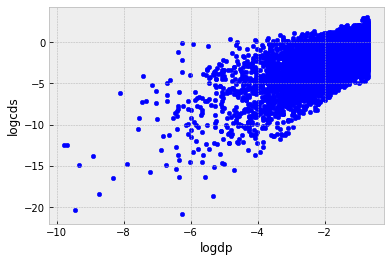

In [6]:
cds_proxy.plot.scatter(x="logdp",y="logcds")

In [7]:
sector = cds_proxy.sector.values
region = cds_proxy.region.values
log_dp = cds_proxy.logdp.values
log_cds = cds_proxy.logcds.values

# pack into dict
dat_cds = {
    "sector": cds_proxy.sector.values,
    "region": cds_proxy.region.values,
    "log_dp": cds_proxy.logdp.values,
    "log_cds": cds_proxy.logcds.values
    }
{k: v[:5] for k, v in dat_cds.items()}

{'log_cds': array([-2.6991176 , -0.65056813,  0.06782693, -2.23320664, -4.95068911]),
 'log_dp': array([-1.5608378 , -1.14972425, -2.35514923, -1.08788098, -3.36251404]),
 'region': array([0, 2, 3, 1, 1]),
 'sector': array([4, 1, 3, 0, 0])}

In [8]:
def model(sector, region, log_dp, log_cds):

    # hyper priors
    a_sector_hyper = numpyro.sample("a_sector_hyper", dist.Normal(0, 1))
    a_sector_sigma = numpyro.sample("a_sector_sigma", dist.Exponential(1))

    b_sector_hyper = numpyro.sample("b_sector_hyper", dist.Normal(0, 1))
    b_sector_sigma = numpyro.sample("b_sector_sigma", dist.Exponential(1))

    a_region_hyper = numpyro.sample("a_region_hyper", dist.Normal(0, 1))
    a_region_sigma = numpyro.sample("a_region_sigma", dist.Exponential(1))

    b_region_hyper = numpyro.sample("b_region_hyper", dist.Normal(0, 1))
    b_region_sigma = numpyro.sample("b_region_sigma", dist.Exponential(1))

    # priors
    a_sector = numpyro.sample("a_sector", dist.Normal(a_sector_hyper, a_sector_sigma).expand([10]))
    b_sector = numpyro.sample("b_sector", dist.Normal(b_sector_hyper, b_sector_sigma).expand([10]))

    a_region = numpyro.sample("a_region", dist.Normal(a_region_hyper, a_region_sigma).expand([4]))
    b_region = numpyro.sample("b_region", dist.Normal(b_region_hyper, b_region_sigma).expand([4]))

    sigma = numpyro.sample("sigma", dist.Exponential(1))
    mu = (a_sector[sector] + a_region[region]) + (b_sector[sector] + b_region[region]) * log_dp
    numpyro.sample("log_cds", dist.Normal(mu, sigma), obs=log_cds)
  

In [9]:
mc_kernel = NUTS(model)
# There are not enough devices to run parallel chains: expected 4 but got 1. Chains will be drawn sequentially.
mcmc_mdl = MCMC(mc_kernel, num_warmup=200, num_samples=1000, num_chains=1)
mcmc_mdl.run(random.PRNGKey(0), sector, region, log_dp, log_cds)
# mcmc_mdl.run(random.PRNGKey(0), **dat_cds)

sample: 100%|██████████| 1200/1200 [06:13<00:00,  3.21it/s, 511 steps of size 6.53e-03. acc. prob=0.89]


In [10]:
mcmc_mdl.print_summary(0.89)


                      mean       std    median      5.5%     94.5%     n_eff     r_hat
     a_region[0]      0.89      0.67      0.87     -0.13      1.96     64.20      1.00
     a_region[1]     -0.65      0.67     -0.67     -1.66      0.46     64.21      1.00
     a_region[2]      1.09      0.67      1.08      0.07      2.19     64.38      1.00
     a_region[3]     -0.82      0.67     -0.81     -1.80      0.32     64.59      1.00
  a_region_hyper      0.08      0.71      0.06     -1.02      1.21    134.89      1.00
  a_region_sigma      1.17      0.47      1.07      0.55      1.81    633.78      1.00
     a_sector[0]     -2.18      0.67     -2.18     -3.29     -1.18     64.40      1.00
     a_sector[1]     -0.31      0.67     -0.29     -1.39      0.73     64.31      1.00
     a_sector[2]      1.11      0.67      1.12     -0.01      2.11     64.07      1.00
     a_sector[3]      0.79      0.67      0.80     -0.31      1.81     64.19      1.00
     a_sector[4]      0.29      0.67      

In [13]:
print("".join(inspect.getsourcelines(mcmc_mdl.sampler.model)[0]))

def model(sector, region, log_dp, log_cds):

    # hyper priors
    a_sector_hyper = numpyro.sample("a_sector_hyper", dist.Normal(0, 1))
    a_sector_sigma = numpyro.sample("a_sector_sigma", dist.Exponential(1))

    b_sector_hyper = numpyro.sample("b_sector_hyper", dist.Normal(0, 1))
    b_sector_sigma = numpyro.sample("b_sector_sigma", dist.Exponential(1))

    a_region_hyper = numpyro.sample("a_region_hyper", dist.Normal(0, 1))
    a_region_sigma = numpyro.sample("a_region_sigma", dist.Exponential(1))

    b_region_hyper = numpyro.sample("b_region_hyper", dist.Normal(0, 1))
    b_region_sigma = numpyro.sample("b_region_sigma", dist.Exponential(1))

    # priors
    a_sector = numpyro.sample("a_sector", dist.Normal(a_sector_hyper, a_sector_sigma).expand([10]))
    b_sector = numpyro.sample("b_sector", dist.Normal(b_sector_hyper, b_sector_sigma).expand([10]))

    a_region = numpyro.sample("a_region", dist.Normal(a_region_hyper, a_region_sigma).expand([4]))
    b_region = numpyro.samp

/usr/local/lib/python3.6/dist-packages/arviz/plots/backends/matplotlib/pairplot.py:240: UserWarning: rcParams['plot.max_subplots'] (40) is smaller than the number of resulting pair plots with these variables, generating only a 8x8 grid
  UserWarning,


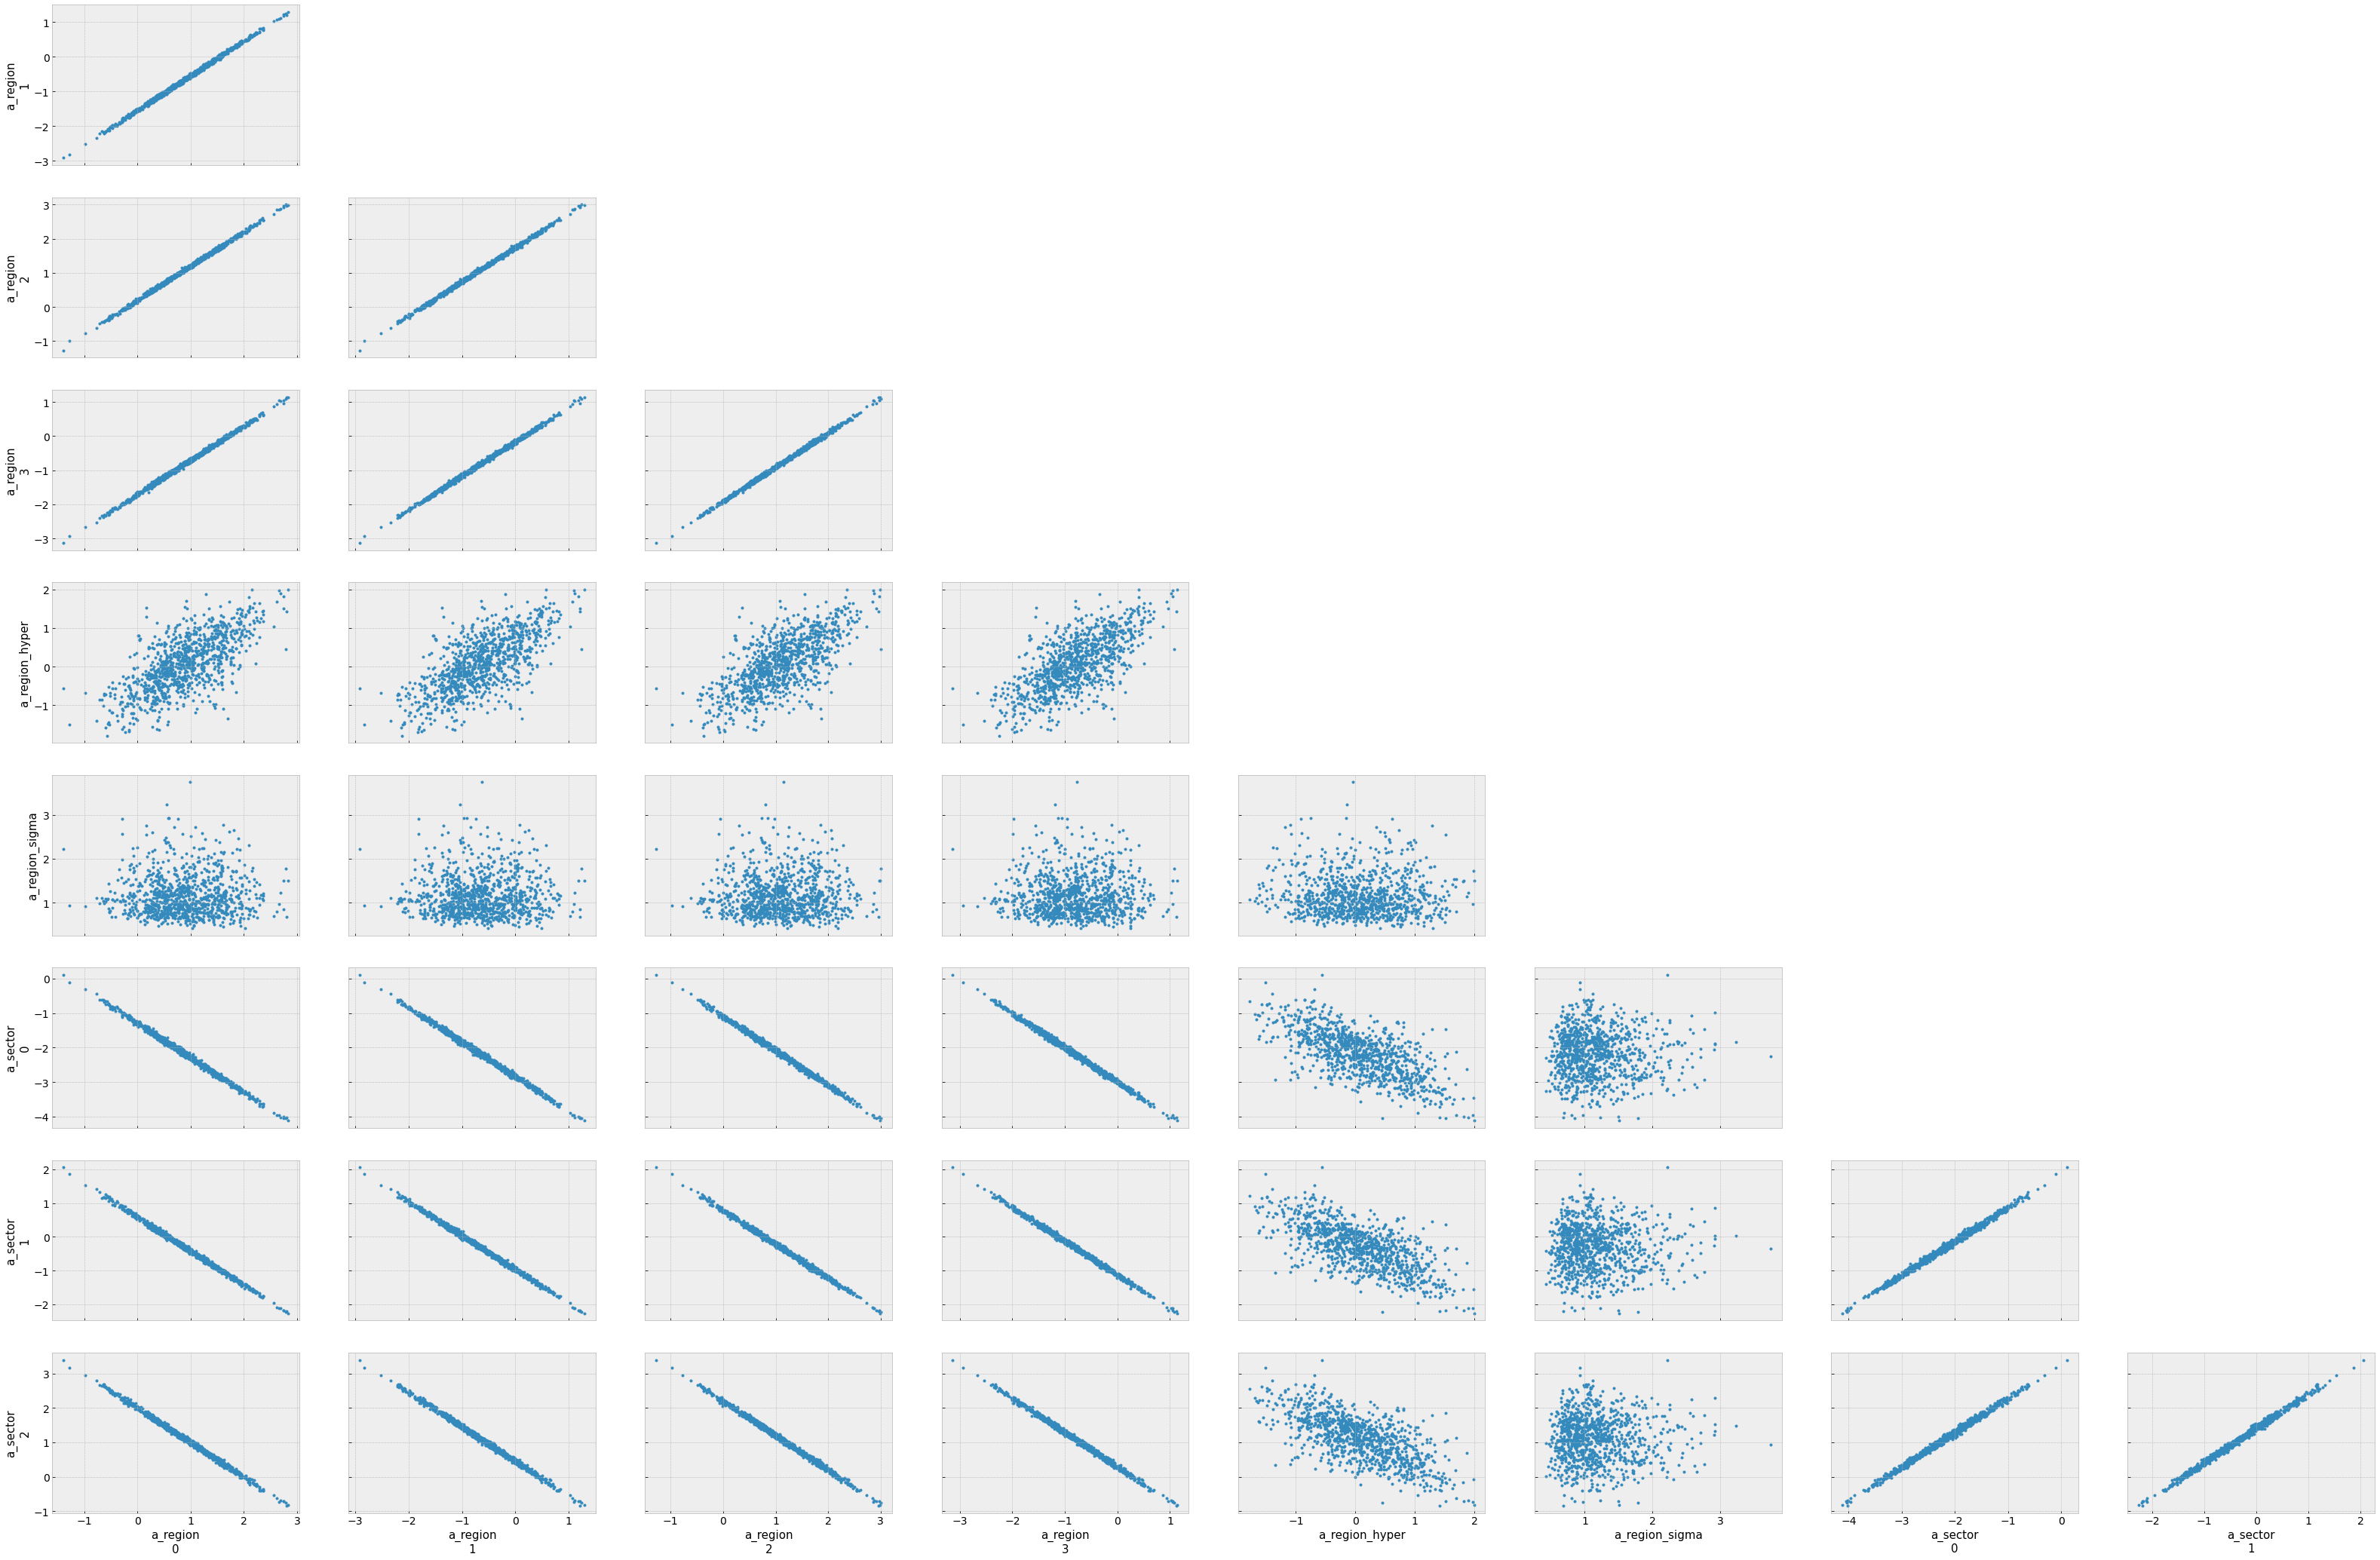

In [15]:
az.plot_pair(az.from_numpyro(mcmc_mdl))
plt.show()

/usr/local/lib/python3.6/dist-packages/arviz/plots/traceplot.py:195: UserWarning: rcParams['plot.max_subplots'] (20) is smaller than the number of variables to plot (37), generating only 20 plots
  UserWarning,


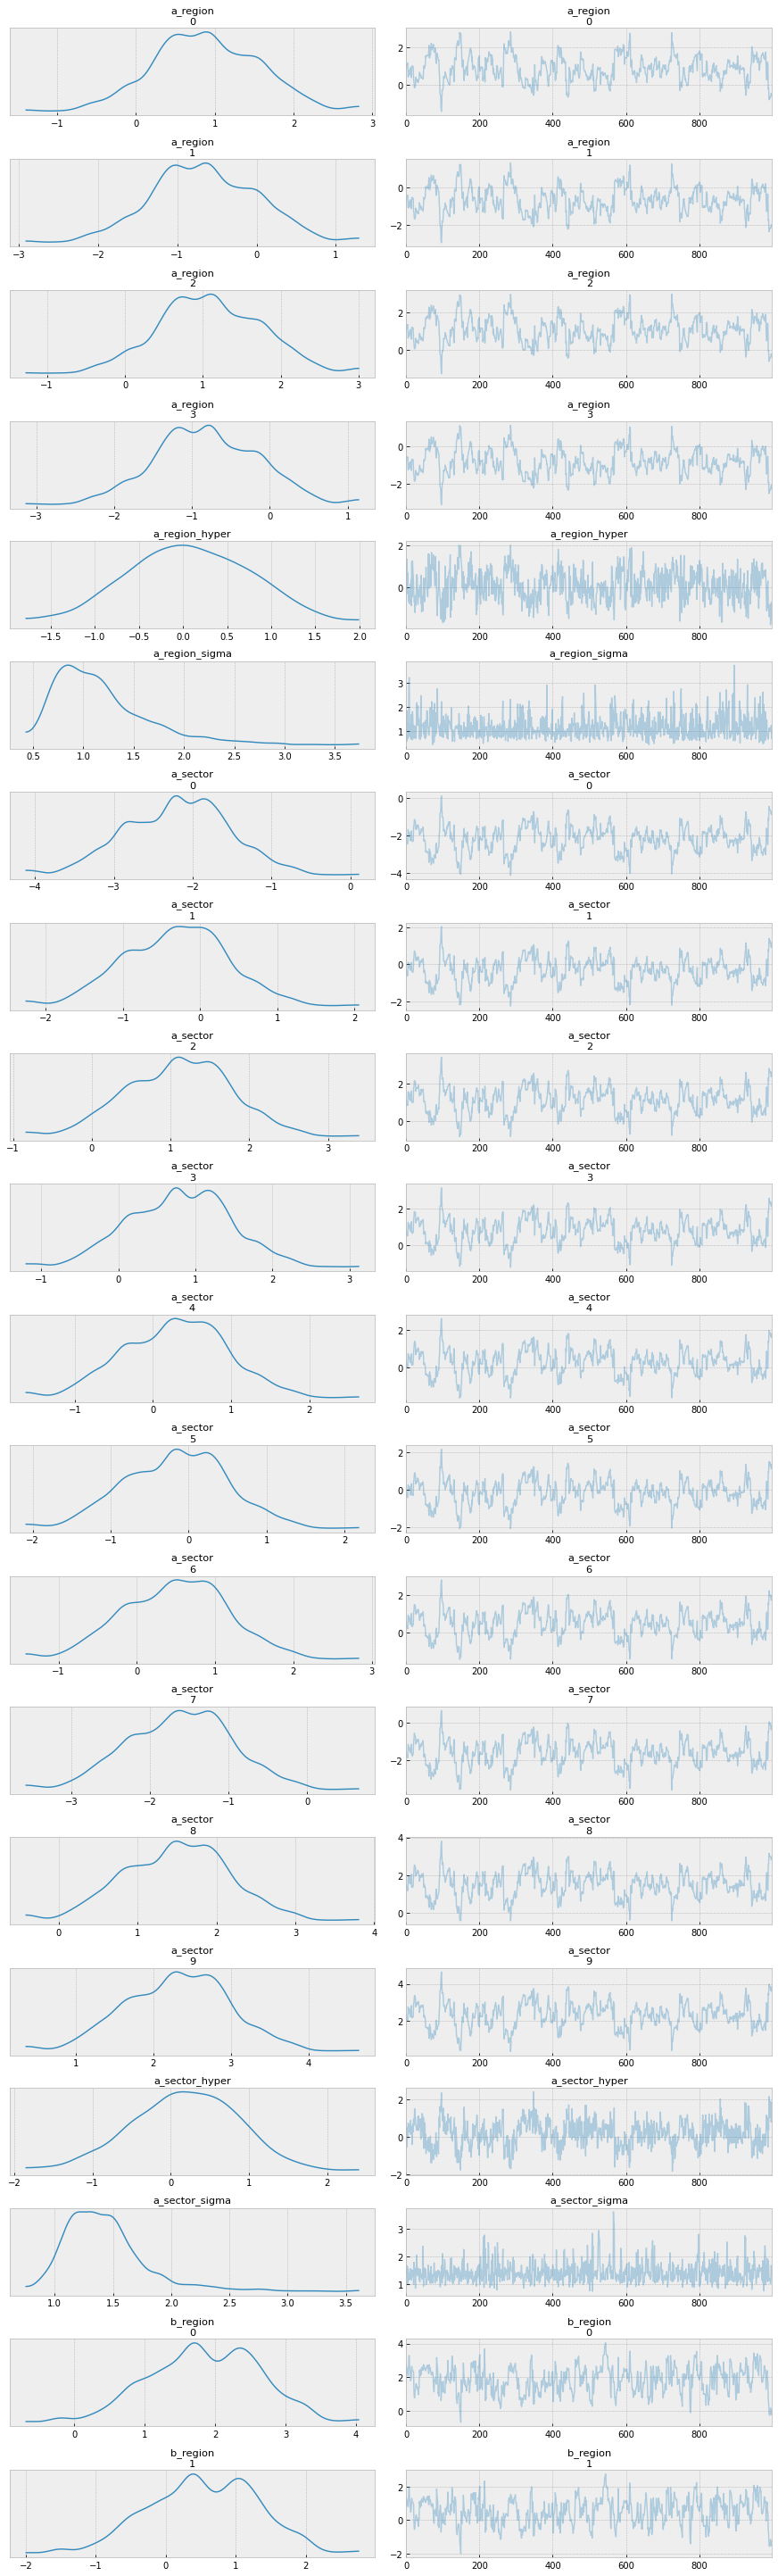

In [16]:
az.plot_trace(az.from_numpyro(mcmc_mdl))
plt.show()

In [28]:
az.style.use("arviz-darkgrid")

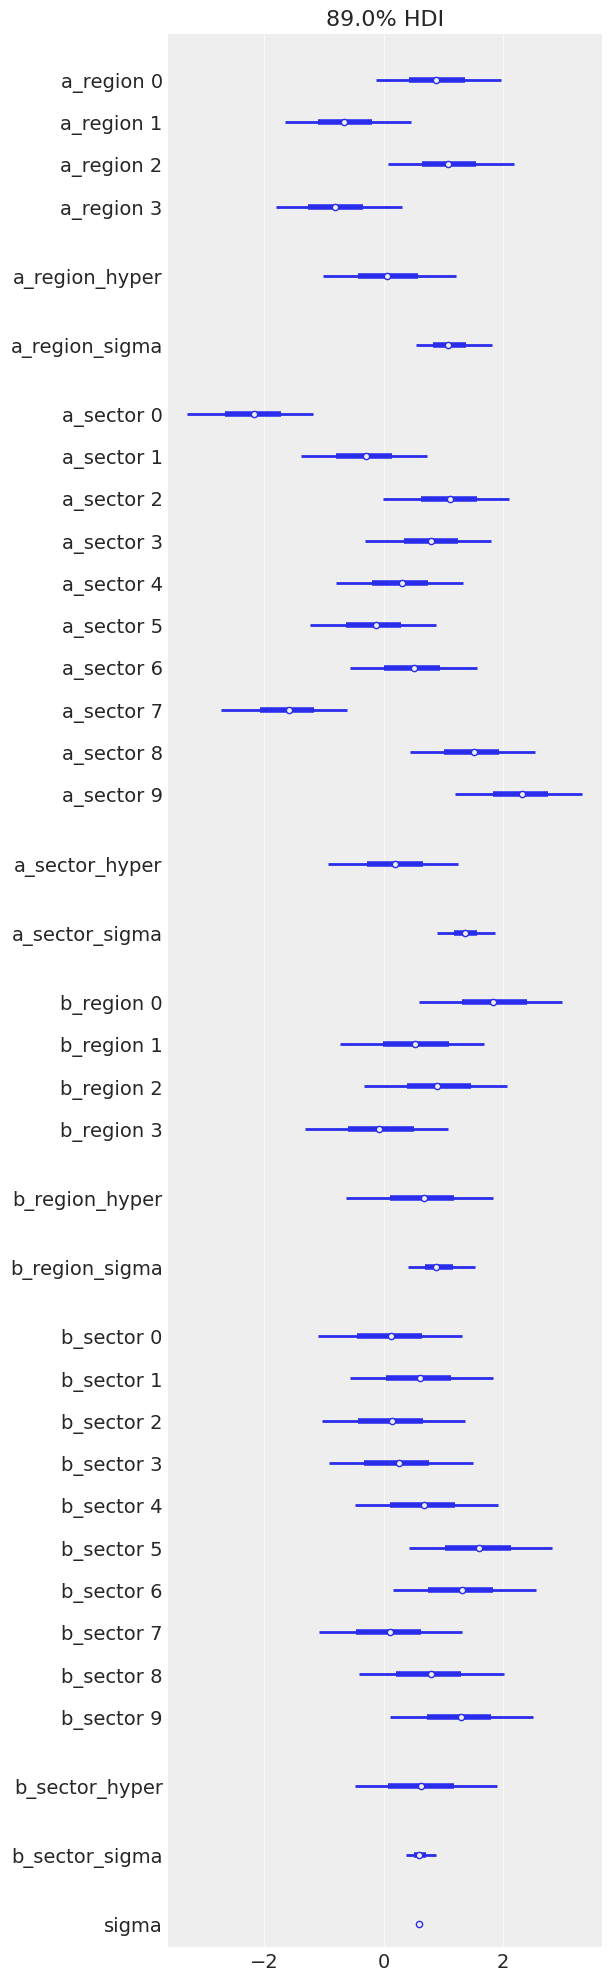

In [29]:
post = mcmc_mdl.get_samples(group_by_chain=True)
az.plot_forest(post, combined=True, hdi_prob=0.89)  # also plot
plt.show()